# Model Training

## Imports

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

2024-12-25 13:22:16.260126: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-25 13:22:16.440038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735129336.508024     728 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735129336.531015     728 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-25 13:22:16.702873: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Loading best result grid search

In [3]:
df = pd.read_csv("image_size_gridsearch_result.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)
df = df.sort_values("test_accuracy", ascending=False)
df.head()

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,support
22,mean,nearest,603,647,0.984753,0.865229,0.789757,0.049925,3.372387,0.705031,0.789757,0.737357,371
32,75%,lanczos3,800,826,0.972197,0.948787,0.765499,0.058881,0.767852,0.708512,0.765499,0.732433,371
15,median,nearest,546,589,0.946188,0.943396,0.752022,0.294562,0.381559,0.719121,0.752022,0.733817,371
17,median,area,546,589,0.970404,0.929919,0.749326,0.144421,1.099276,0.705493,0.749326,0.724976,371
30,75%,bicubic,800,826,0.954260,0.948787,0.746631,0.201048,0.450455,0.699765,0.746631,0.720736,371


Class_weight is overgenomen uit notebook 4

In [4]:
best_result = df.iloc[0]
width = best_result["width"]
height = best_result["height"]
statistic = best_result["statistic"]
interpolation = best_result["interpolation"]
painters = ["Mondriaan", "Picasso"]
base_dir = "imbalanced_dataset"
class_weight = {0: 2.8156565656565657, 1: 0.6079607415485279}

## Helper functions

In [5]:
def build_model(width, height, data_augmentation=None):
    model_layers = [
        layers.InputLayer(shape=(width, height, 3)),
    ]
    if data_augmentation:
        model_layers.append(data_augmentation)
    
    model_layers.extend([
        layers.Rescaling(1./255),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(256, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(256, 3, activation='relu'),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid'),
    ])
    
    model = keras.Sequential(model_layers)
    return model

model = build_model(width, height)
model.summary()

I0000 00:00:1735129398.498137     728 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 603, 647, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 601, 645, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 300, 322, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 298, 320, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 149, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 147, 158, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 73, 79, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 71, 77, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 35, 38, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 33, 36, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 304128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       304,129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282,625 (4.89 MB)

 Trainable params: 1,282,625 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
def plot_info(axes, type):
    axes.set_title(type)
    axes.set_xlabel("Epochs")
    axes.set_ylabel("Loss")
    axes.legend()
    axes.grid()

def plot_loss(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs_range = range(1, len(history.history["loss"]) + 1)

    _, axes = plt.subplots(4,1, figsize=(12,18))
    axes[0].plot(epochs_range, loss, label="Training loss")
    axes[0].plot(epochs_range, val_loss, label="Validation loss")
    plot_info(axes[0], "Lineair")
    

    axes[1].semilogy(epochs_range, loss, label="Training loss")
    axes[1].semilogy(epochs_range, val_loss, label="Validation loss")
    plot_info(axes[1], "Logarithmic")

    axes[2].plot(epochs_range, acc, label="Training accuracy")
    axes[2].plot(epochs_range, val_acc, label="Validation accuracy")
    plot_info(axes[2], "Lineair")

    axes[3].semilogy(epochs_range, acc, label="Training accuracy")
    axes[3].semilogy(epochs_range, val_acc, label="Validation accuracy")
    plot_info(axes[3], "Logarithmic")

In [11]:
def load_dataset(base_dir, painters, width, height, batch_size=16, interpolation="bilinear"):
    train_dataset = image_dataset_from_directory(
        f'{base_dir}/train',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    validation_dataset = image_dataset_from_directory(
        f'{base_dir}/validation',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    test_dataset = image_dataset_from_directory(
        f'{base_dir}/test',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    return train_dataset, validation_dataset, test_dataset

train, val, test = load_dataset(base_dir, painters, width, height, interpolation=interpolation)

Found 1115 files belonging to 2 classes.
Found 744 files belonging to 2 classes.
Found 744 files belonging to 2 classes.


In [8]:
def print_classifiction_report(model, test_dataset):
    y_pred = model.predict(test_dataset)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
    print(classification_report(y_true, y_pred, zero_division=0))

## Model training

### Model listing 8.7

In [8]:
model = build_model(width, height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="listing_8.7.keras",
save_best_only=True,
monitor="val_loss")
]


history = model.fit(train, epochs=20, validation_data=val, class_weight=class_weight, callbacks=callbacks)

Found 1115 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
Epoch 1/20


I0000 00:00:1735038750.659076   14521 service.cc:148] XLA service 0x7ff7540097c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735038750.659245   14521 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-12-24 12:12:30.718638: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735038751.053605   14521 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/70 ━━━━━━━━━━━━━━━━━━━━ 17:51 16s/step - accuracy: 0.9375 - loss: 0.7046

I0000 00:00:1735038765.319922   14521 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/70 ━━━━━━━━━━━━━━━━━━━━ 38s 321ms/step - accuracy: 0.6487 - loss: 1.6066 - val_accuracy: 0.7628 - val_loss: 0.6899
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.6008 - loss: 0.7071 - val_accuracy: 0.1806 - val_loss: 2.5558
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.5850 - loss: 0.7739 - val_accuracy: 0.7035 - val_loss: 0.5865
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.6619 - loss: 0.6951 - val_accuracy: 0.8329 - val_loss: 0.3766
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.6913 - loss: 0.6427 - val_accuracy: 0.6927 - val_loss: 0.5877
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.7182 - loss: 0.5306 - val_accuracy: 0.7925 - val_loss: 0.4284
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.7331 - loss: 0.5364 - val_accuracy: 0.5526 - val_loss: 1.2294
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.7781 - loss: 0.4872 - val_accuracy: 0.5364 - val

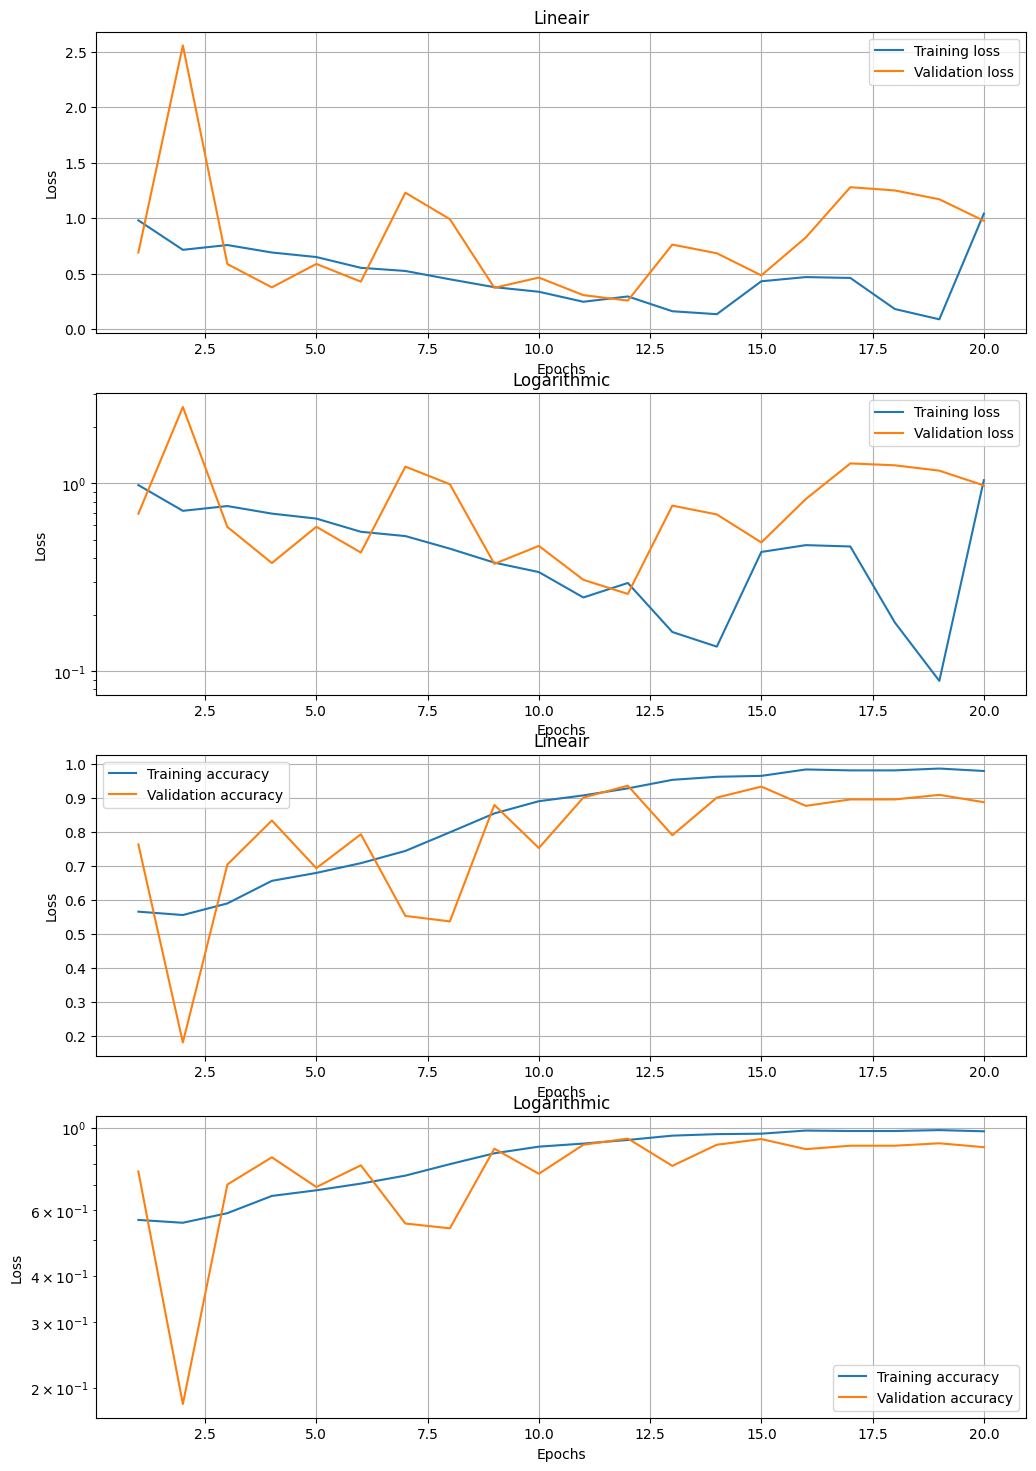

In [9]:
plot_loss(history)

In [10]:
print_classifiction_report(model, test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
              precision    recall  f1-score   support

           0       0.20      0.21      0.21        66
           1       0.83      0.82      0.82       305

    accuracy                           0.71       371
   macro avg       0.51      0.51      0.51       371
weighted avg       0.72      0.71      0.71       371



2024-12-24 12:16:03.504593: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Model listing 8.7 met data augmentation 8.14

In [11]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
model = build_model(width, height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="listing_8.7_data_augmentation.keras",
save_best_only=True,
monitor="val_loss")
]

history = model.fit(train, epochs=20, validation_data=val, class_weight=class_weight, callbacks=callbacks)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 0.6133 - loss: 2.0022 - val_accuracy: 0.7089 - val_loss: 0.6333
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.5596 - loss: 0.7129 - val_accuracy: 0.8221 - val_loss: 0.7329
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.5232 - loss: 0.7384 - val_accuracy: 0.5094 - val_loss: 0.6333
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.5564 - loss: 0.6264 - val_accuracy: 0.8329 - val_loss: 0.4975
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.6594 - loss: 0.6263 - val_accuracy: 0.7736 - val_loss: 0.4677
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.6838 - loss: 0.6420 - val_accuracy: 0.8032 - val_loss: 0.4014
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.7320 - loss: 0.6078 - val_accuracy: 0.8086 - val_loss: 0.4341
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.8063 - loss: 0.6079 - val_accuracy: 

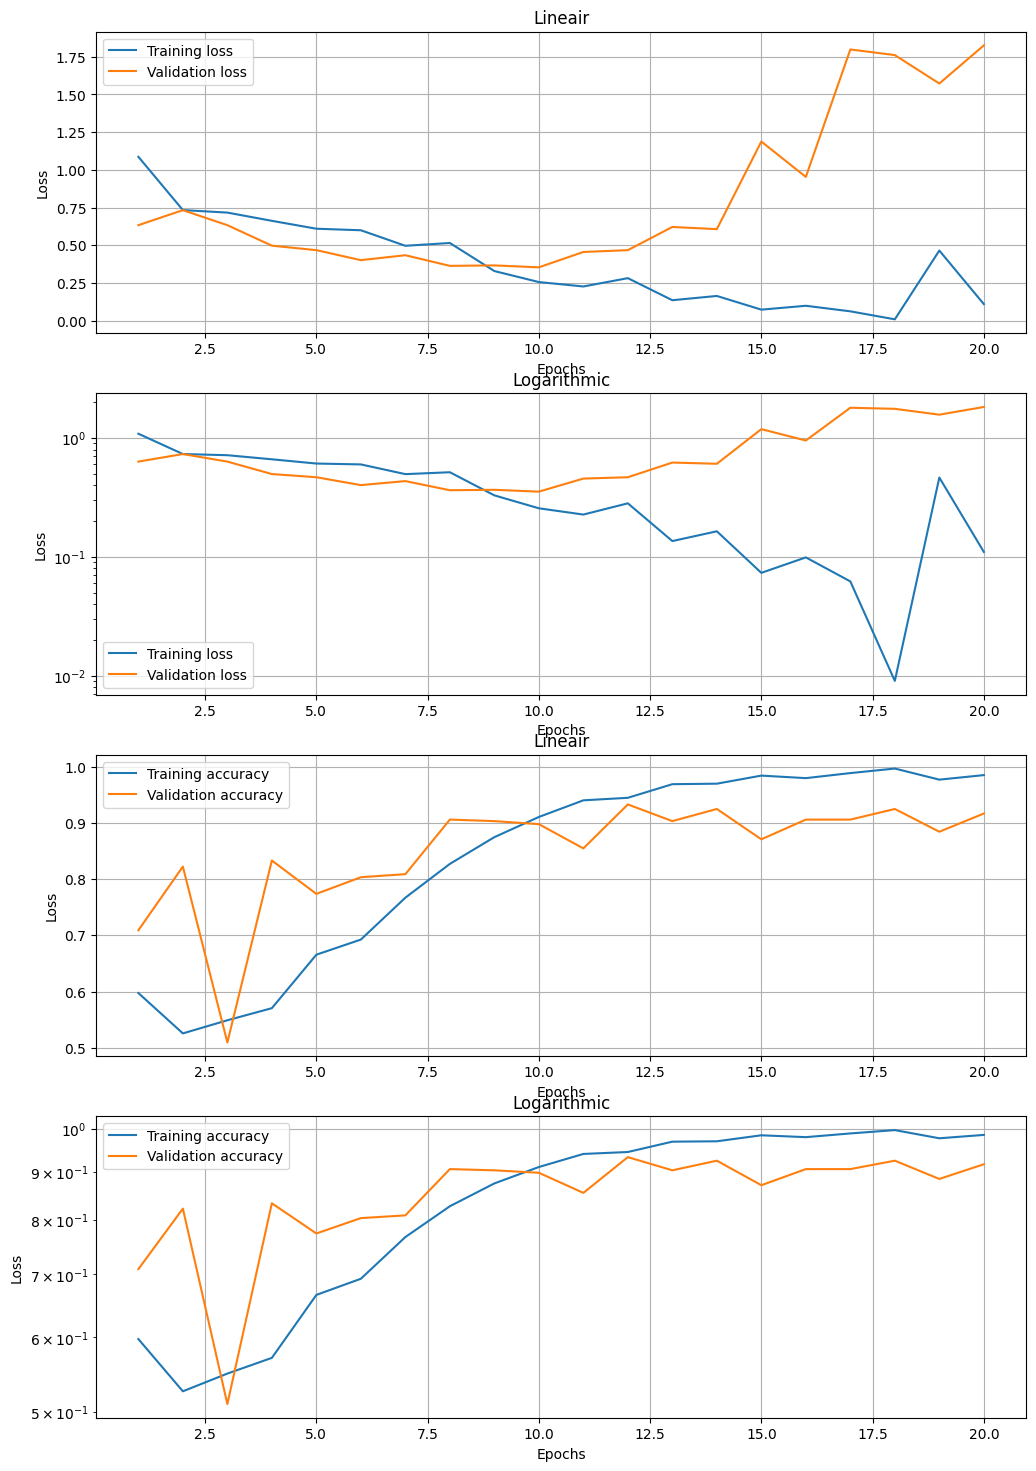

In [12]:
plot_loss(history)

In [13]:
print_classifiction_report(model, test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
              precision    recall  f1-score   support

           0       0.15      0.14      0.14        66
           1       0.82      0.83      0.82       305

    accuracy                           0.70       371
   macro avg       0.48      0.48      0.48       371
weighted avg       0.70      0.70      0.70       371



2024-12-24 12:19:14.772030: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Model listing 8.16

In [17]:
inputs = keras.Input(shape=(width, height, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
optimizer="rmsprop",
metrics=["accuracy"])

callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="listing_8.16.keras",
save_best_only=True,
monitor="val_loss")
]

history = model.fit(train, epochs=50, validation_data=val, class_weight=class_weight)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.5424 - loss: 0.8537 - val_accuracy: 0.2129 - val_loss: 0.7844
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.5226 - loss: 0.7736 - val_accuracy: 0.1779 - val_loss: 2.8022
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.6387 - loss: 0.7336 - val_accuracy: 0.5795 - val_loss: 0.6645
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.6124 - loss: 0.6752 - val_accuracy: 0.8248 - val_loss: 0.6301
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.6604 - loss: 0.6667 - val_accuracy: 0.2803 - val_loss: 1.1653
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.5719 - loss: 0.6639 - val_accuracy: 0.4340 - val_loss: 0.7474
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.5870 - loss: 0.6253 - val_accuracy: 0.3989 - val_loss: 0.9048
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 0.6073 - loss: 0.5950 - val_accu

2024-12-24 12:29:19.295524: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554752 bytes after encountering the first element of size 33554752 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.7613 - loss: 0.5633 - val_accuracy: 0.7871 - val_loss: 0.4447
Epoch 30/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.7496 - loss: 0.5529 - val_accuracy: 0.8518 - val_loss: 0.4244
Epoch 31/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.7998 - loss: 0.5581 - val_accuracy: 0.7628 - val_loss: 0.6044
Epoch 32/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.8118 - loss: 0.5564 - val_accuracy: 0.8841 - val_loss: 0.4274
Epoch 33/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.8582 - loss: 0.4911 - val_accuracy: 0.8760 - val_loss: 0.3147
Epoch 34/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.8308 - loss: 0.4179 - val_accuracy: 0.8248 - val_loss: 0.4654
Epoch 35/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.7825 - loss: 0.5357 - val_accuracy: 0.8464 - val_loss: 0.6052
Epoch 36/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.7681 - loss: 0.5598 - val_accuracy

2024-12-24 12:32:56.907392: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554752 bytes after encountering the first element of size 33554752 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - accuracy: 0.8260 - loss: 0.4492 - val_accuracy: 0.7790 - val_loss: 0.7281
Epoch 50/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.7322 - loss: 0.7538 - val_accuracy: 0.7790 - val_loss: 0.5248


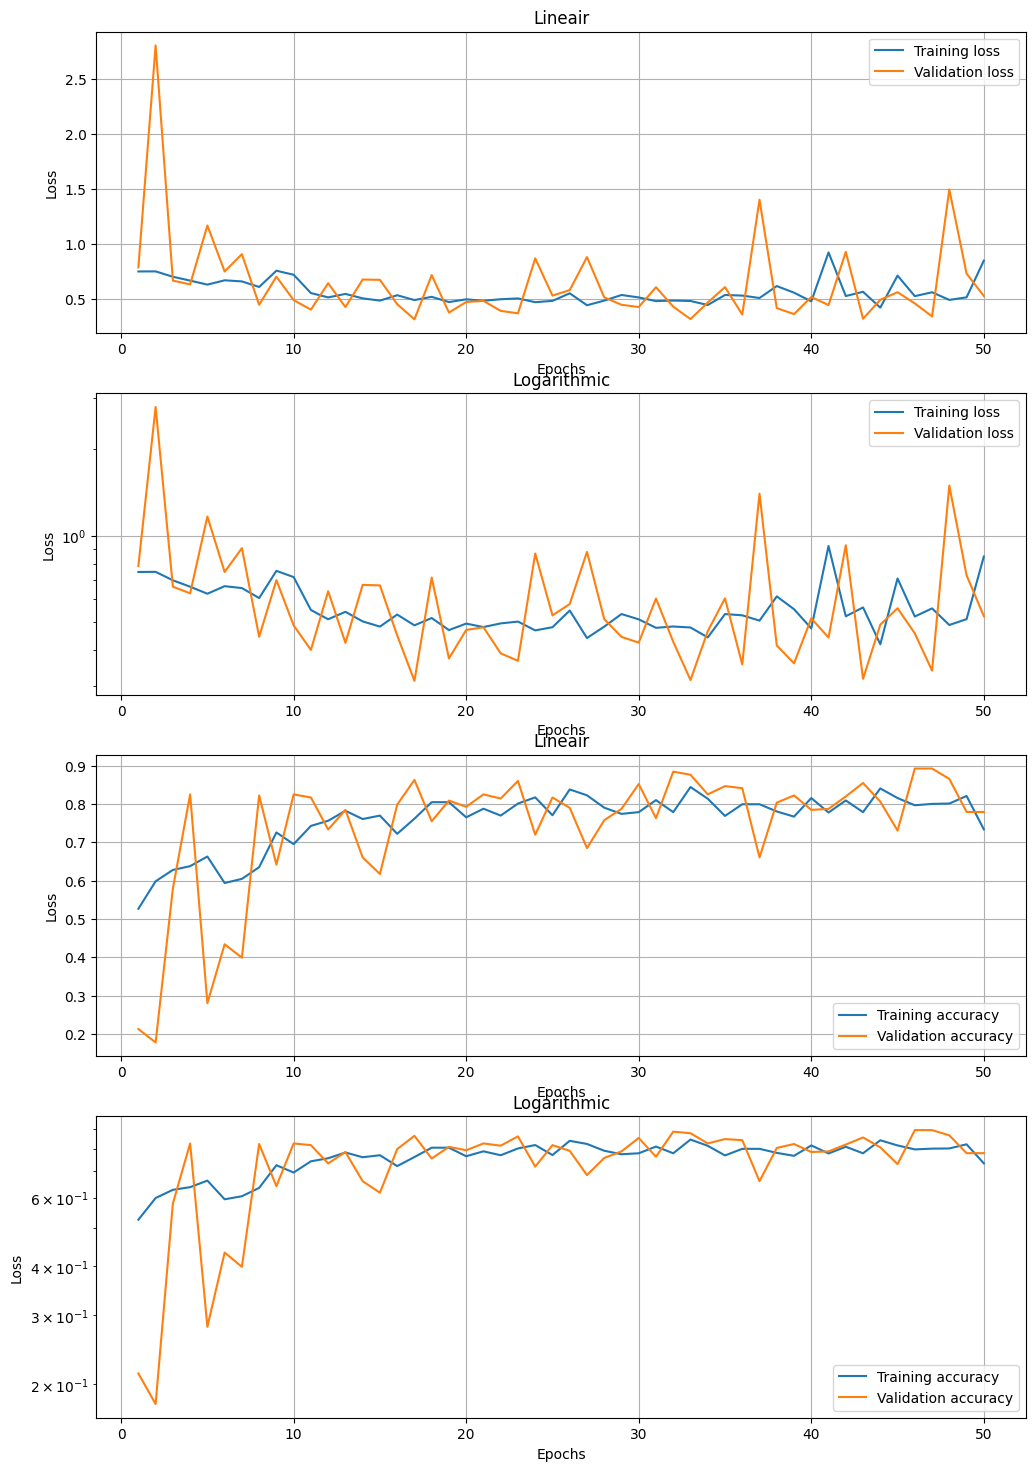

In [18]:
plot_loss(history)

In [19]:
print_classifiction_report(model, test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
              precision    recall  f1-score   support

           0       0.20      0.39      0.27        66
           1       0.84      0.67      0.74       305

    accuracy                           0.62       371
   macro avg       0.52      0.53      0.50       371
weighted avg       0.72      0.62      0.66       371



2024-12-24 14:25:27.413883: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Listing 8.19

In [9]:
conv_base = keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=(width, height, 3))
conv_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 603, 647, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 603, 647, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 603, 647, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 301, 323, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 301, 323, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 301, 323, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 150, 161, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 150, 161, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 150, 161, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 150, 161, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 75, 80, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 75, 80, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 75, 80, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 75, 80, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 37, 40, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 37, 40, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 37, 40, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 37, 40, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 18, 20, 512)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)
train_features, train_labels = get_features_and_labels(train)
val_features, val_labels = get_features_and_labels(val)
test_features, test_labels = get_features_and_labels(test)

I0000 00:00:1735129649.470190    1370 service.cc:148] XLA service 0x7f30000070e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735129649.470554    1370 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-12-25 13:27:29.488335: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735129649.544274    1370 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-25 13:27:31.656317: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.99GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-25 13:27:31.656385: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_b

1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


KeyboardInterrupt: 